In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals
import sys, os, datetime, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.integrate import quad
!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Regression Task

We use the following function for training data with support x∈[0,1]:

<img src="https://i.postimg.cc/VL0tDL5h/Code-Cogs-Eqn-3.png" width="100">

Factors that may affect the results:

1. Distribution of Training set. X is generated with uniform distribution.
2. Structure of NN. 2 layers [5, 1]

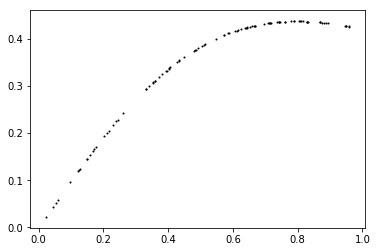

In [0]:
f=lambda x:np.sin(x)/(1+x**2)
x = [np.random.uniform() for i in range(100)]
y = [f(i) for i in x]
plt.scatter(x,y, c='black', s=1)

### Benchmark Errors (MSE only)

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
  plt.ylim([0,np.max(hist['loss'])/50])
  plt.legend()
  plt.show()
  
def build_model(if_print=False):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(1)])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',optimizer=optimizer)
  if if_print: model.summary()
  return model

def get_data(data_size=10000):
  f=lambda x:np.sin(x)/(1+x**2)
  x = [np.random.uniform() for i in range(data_size)]
  y = [f(i) for i in x]
  return x,y

def get_errors(model, x, y, if_train=False, if_print_weights=False, if_print_errors_stats=False):
  
  if if_train:
    history = model.fit(x, y, epochs=200, validation_split = 0.2, verbose=0)
    plot_history(history)
  
  if if_print_weights:
    print("layer 1 weights:", ', '.join([str(item) for item in model.layers[0].trainable_variables[0].numpy()]))
    print("layer 1 bias:", ', '.join([str(item) for item in model.layers[0].trainable_variables[1].numpy()]))
    print("layer 2 weights:", ', '.join([str(item) for item in model.layers[1].trainable_variables[0].numpy()]))
    print("layer 2 bias:", ', '.join([str(item) for item in model.layers[1].trainable_variables[1].numpy()]))
    
  y_pred = model.predict(x)
  y_pred = y_pred.reshape(-1)
  errors = y - y_pred
  #errors = [np.abs(i) for i in errors]
  mean = np.mean(errors)
  sigma = np.sqrt(np.var(errors))
  if if_print_errors_stats:

    print("\nmean of errors:", mean)
    print("standard deviation of errors:", sigma)
  
  return errors, mean, sigma

#model = build_model(1)
#x, y = get_data(1000)
#errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)

In [0]:
def get_kde(errors):
  kde=stats.gaussian_kde(errors)
  kde.set_bandwidth(bw_method=kde.factor/10)
  return kde
def plot_errors(errors):
  errors_sigma = np.sqrt(np.var(errors))
  plt.figure(figsize=(20, 8))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(hspace=1)

  p1 = plt.subplot(311)
  p1.title.set_text("Errors Histogram")
  weights = np.ones_like(errors)/float(len(errors))
  _, _, _ = plt.hist(errors, weights=weights,bins=100, color='red')

  p2 = plt.subplot(312)
  p2.title.set_text('Errors PDF')

  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)
  kde = get_kde(errors)
  y1 = kde(x1)
  plt.plot(x1, y1, color='black', linewidth=1)
  plt.plot(errors, np.full_like(errors, -0.1), '|k', markeredgewidth=1)

  p3 = plt.subplot(313)
  p3.title.set_text("Normal Distribution")
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  plt.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
  plt.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
  plt.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)

#plot_errors(errors)

### Benchmark Loss (Target Normal)

In [0]:
def normal_distribution_function(x,mean,std):
  value = scipy.stats.norm.pdf(x,mean,std)
  return value
  
def kde_function(x, errors):
  kde = get_kde(errors)
  value = kde(x)
  return value
  
def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array - value)).argmin()
  return array[idx], idx
  
def get_loss(errors, if_print=False, if_plot=False):
  
  errors_sigma = np.sqrt(np.var(errors))
  x1 = np.linspace(np.min(errors), np.max(errors), num=10000)

  kde = get_kde(errors)
  y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
  y1 = kde(x1)
  idx = np.argwhere(np.diff(np.sign(y_norm - y1))).flatten()
  
  x1_0, x1_0_idx = find_nearest(x1,0)
  crosspoint_1_idx, tmp = find_nearest(idx, x1_0_idx)
  idx = np.delete(idx, tmp, 0)
  crosspoint_2_idx, _ = find_nearest(idx, x1_0_idx)
  crosspoint_1, crosspoint_2 = x1[crosspoint_1_idx], x1[crosspoint_2_idx]
  if crosspoint_1 > crosspoint_2:
    crosspoint_1, crosspoint_2=crosspoint_2, crosspoint_1
    crosspoint_1_idx, crosspoint_2_idx=crosspoint_2_idx, crosspoint_1_idx
    
  norm_area, norm_err = quad(normal_distribution_function, crosspoint_1, crosspoint_2, args=(0,errors_sigma/4,))
  kde_area, kde_err = quad(kde_function, crosspoint_1, crosspoint_2, args=(errors))
  
  if if_print:
    print("Errors Min:", np.min(errors), ", Errors Max:", np.max(errors))
    print("Crosspoint Index:", crosspoint_1_idx, "and", crosspoint_2_idx, "out of 10000 points")
    print("\nLeft crosspoint:", crosspoint_1, ", Right crosspoint:", crosspoint_2)
    print("Area of Normal (between the crosspoints):", norm_area)
    print("Area of Errors (between the crosspoints):", kde_area)
    print("Loss(blue area):", norm_area-kde_area)
    
  if if_plot:
    plt.figure(figsize=(20, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(211)
    diffs=[np.abs(stats.norm.pdf(i, 0, errors_sigma/4)-kde(i))[0] for i in x1]
    p1.plot(x1, diffs)
    p1.scatter(np.array([crosspoint_1, crosspoint_2]), np.array([diffs[crosspoint_1_idx],diffs[crosspoint_2_idx]]), color="black")
    plt.xlim(np.min(errors), np.max(errors))
    p1.title.set_text("Difference between Normal and Errors")

    p2 = plt.subplot(212)
    y_norm = stats.norm.pdf(x1, 0, errors_sigma/4)
    p2.plot(x1, y1, x1, y_norm, color='black', linewidth=1)
    p2.fill_between(x1, y1, y_norm, where=y_norm >= y1, facecolor='blue', interpolate=True)
    p2.fill_between(x1, y1, y_norm, where=y_norm <= y1, facecolor='red', interpolate=True)
    idx1=np.where(crosspoint_1)
    xs = np.array([crosspoint_1, crosspoint_2])
    ys = np.array([y1[crosspoint_1_idx],y1[crosspoint_2_idx]])
    p2.scatter(xs, ys, color="black")
    plt.xlim(np.min(errors), np.max(errors))
    
  return norm_area-kde_area

#benchmark_loss = get_loss(model, errors, if_print=1, if_plot=1)

### Approximate Gradient

In [49]:
def node_plus_delta(model, layer_n, wb_n, node_n, if_print=False, delta = 10**(-6)):
  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)
  
  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
      
  weight_new = weight_old + delta_extend
  if if_print: print("\n OLD: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\n NEW: model.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  return weight_old

def node_minus_delta(model, layer_n, wb_n, node_n, if_print=False, delta = 10**(-6)):
  weight_old = model.layers[layer_n].trainable_variables[wb_n].numpy()
  delta_extend = np.zeros(weight_old.shape)

  if layer_n == 0:
    if wb_n==0:
      delta_extend[0][node_n] = delta
    elif wb_n==1:
      delta_extend[node_n] = delta
  elif layer_n == 1:
    if wb_n==0:  
      delta_extend[node_n] = delta
    elif wb_n==1:
      delta_extend = delta
    
  weight_new = weight_old - delta_extend
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  model.layers[layer_n].trainable_variables[wb_n].assign(weight_new)
  if if_print: print("\nmodel.layers[", layer_n, "].trainable_variables[", wb_n, "] with node_n as", node_n, ":\n", model.layers[layer_n].trainable_variables[wb_n])
  return weight_old

def node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n=1):
  for i in range(delta_n):
    node_plus_delta(model, layer_n, wb_n, node_n, if_print=0)
  errors, mean, var = get_errors(model, x, y)
  loss = get_loss(errors)
  
  for i in range(delta_n):
    node_minus_delta(model, layer_n, wb_n, node_n)
  return loss

def check_node_loss(model, x, y, layer_n, wb_n, node_n, benchmark_loss):
  node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n)
  delta_n = 1
  n=0
  while benchmark_loss == node_loss and n<10: 
    n+=1
    delta_n+=1
    node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
  
  if n==10:
    while benchmark_loss == node_loss and n<20: 
      n+=1
      delta_n+=10
      node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
      
  if n==20:
    while benchmark_loss == node_loss and n<30: 
      n+=1
      delta_n+=100
      node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
      
  if n==30:
    while benchmark_loss == node_loss and n<40: 
      n+=1
      delta_n+=1000
      node_loss = node_plus_delta_loss(model, x, y, layer_n, wb_n, node_n, delta_n)
    
  return node_loss, delta_n

def nodes_plus_delta_loss(model, x, y, benchmark_loss):
  layer_0_w_losses = []
  layer_0_b_losses = []
  layer_1_w_losses = []
  layer_1_b_losses = []
  
  layer_0_w_delta_n = []
  layer_0_b_delta_n = []
  layer_1_w_delta_n = []
  layer_1_b_delta_n = []
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 0, 0, i, benchmark_loss=benchmark_loss)
    layer_0_w_losses.append(loss)
    layer_0_w_delta_n.append(delta_n)
    #print(i)
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 0, 1, i, benchmark_loss=benchmark_loss)
    layer_0_b_losses.append(loss)
    layer_0_b_delta_n.append(delta_n)
    #print(i)
  
  #print("-----")
  for i in range(5):
    loss, delta_n = check_node_loss(model, x, y, 1, 0, i, benchmark_loss=benchmark_loss)
    layer_1_w_losses.append(loss)
    layer_1_w_delta_n.append(delta_n)
    #print(i)
   
  loss, delta_n = check_node_loss(model, x, y, 1, 1, 0, benchmark_loss=benchmark_loss)                                
  layer_1_b_losses.append(loss)
  layer_1_b_delta_n.append(delta_n)
  
  nodes_losses = [layer_0_w_losses, layer_0_b_losses, layer_1_w_losses, layer_1_b_losses]
  nodes_delta_n = [layer_0_w_delta_n, layer_0_b_delta_n, layer_1_w_delta_n, layer_1_b_delta_n]
  return nodes_losses,nodes_delta_n

"""
start_time = time.time()
nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y)
print("--- %s seconds ---" % (time.time() - start_time))
print("benchmark loss:", benchmark_loss)
print("nodes loss:", nodes_losses)
print("nodes_delta_n:", nodes_delta_n)
"""

'\nstart_time = time.time()\nnodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y)\nprint("--- %s seconds ---" % (time.time() - start_time))\nprint("benchmark loss:", benchmark_loss)\nprint("nodes loss:", nodes_losses)\nprint("nodes_delta_n:", nodes_delta_n)\n'

In [0]:
def get_gradient(nodes_losses, nodes_delta_n, benchmark_loss):
  gradients = []
  for i in range(len(nodes_losses)):
    grads = []
    for j in range(len(nodes_losses[i])):
      grad = (nodes_losses[i][j])/(nodes_delta_n[i][j]**10**-6)
      grads.append(grad)
    gradients.append(grads)
    
  return gradients

#grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
#print(grads)

In [0]:
def update_nodes(model, grads, nodes_delta_n, if_print = False, lr = 0.001):
  if if_print: 
    print("\n OLD:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
  for i in range(len(grads)):
    for j in range(len(grads[i])):
      delta = lr*grads[i][j]*nodes_delta_n[i][j]*10**(-6)
      #print("---------")
      #print("nodes_delta_n:", nodes_delta_n[i][j])
      #print("lr:", lr)
      #print("grad:", grads[i][j])
      #print("delta:", delta)
      node_plus_delta(model, layer_n=0 if i<2 else 1, wb_n=i%2, node_n=j, delta = -delta)
      
  if if_print: 
    print("\n NEW:")
    print("model.layers[0].trainable_variables[0]:", model.layers[0].trainable_variables[0])
    print("model.layers[0].trainable_variables[1]:", model.layers[0].trainable_variables[1])
    print("model.layers[1].trainable_variables[0]:", model.layers[1].trainable_variables[0])
    print("model.layers[1].trainable_variables[1]:", model.layers[1].trainable_variables[1])
    
  return model

#model=update_nodes(model, grads, nodes_delta_n, if_print=0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


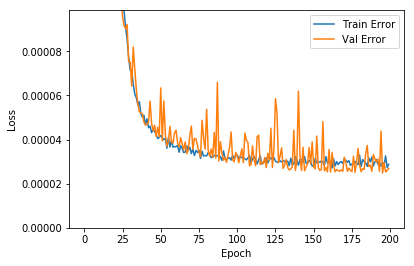

layer 1 weights: [-0.217062   0.3752277  0.9191568  0.7827074 -0.5553198]
layer 1 bias: 0.0, -0.24677578, 0.004367231, -0.27867126, 0.0
layer 2 weights: [-0.93344784], [-1.0749803], [0.95762575], [-0.638381], [0.05442262]
layer 2 bias: 0.006348879

mean of errors: -0.0014298970874394776
standard deviation of errors: 0.0048494799157677215
Errors Min: -0.014391347737170379 , Errors Max: 0.0049055965162339565
Crosspoint Index: 6249 and 8408 out of 10000 points

Left crosspoint: -0.0023314812865729492 , Right crosspoint: 0.0018351456404297473
Area of Normal (between crosspoints): 0.9077118943450138
Area of Errors (between crosspoints): 0.2961633589435546
Loss(blue area): 0.6115485354014591

Initial loss: 0.6115485354014591
-----Epoch 0
New loss: 0.6115835732430193
-----Epoch 1
New loss: 0.6116235386745025
-----Epoch 2
New loss: 0.6116585614558614
-----Epoch 3
New loss: 0.6116959488947873
-----Epoch 4
New loss: 0.6117298670887819
-----Epoch 5
New loss: 0.6117711279522197
-----Epoch 6
New lo

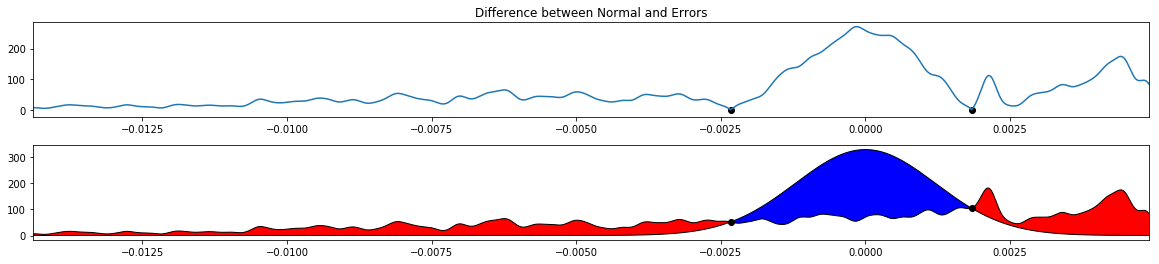

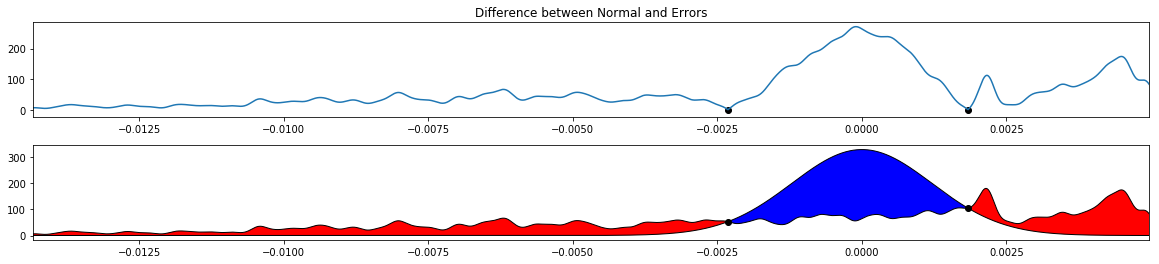

In [22]:
def train_dist(epoch_n=50):
  
  model = build_model(1)
  x, y = get_data(1000)
  errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)
  benchmark_loss = get_loss(errors, if_print=1, if_plot=1)
  print("\nInitial loss:", benchmark_loss)
  
  
  for i in range(epoch_n):
    print("-----Epoch", i)
    if i < (epoch_n-1): if_print=0
    else: if_print=1
      
    # estimate gradient
    nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y, benchmark_loss)
    grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
    
    # update weights
    model=update_nodes(model, grads, nodes_delta_n, if_print=if_print)
    errors, mean, sigma = get_errors(model, x, y, if_train=0, if_print_weights=if_print, if_print_errors_stats=if_print)
    new_loss = get_loss(errors, if_print=if_print, if_plot=if_print)
    print("New loss:", new_loss)
  
start_time = time.time()
train_dist()
print("--- %s seconds ---" % (time.time() - start_time))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 6         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


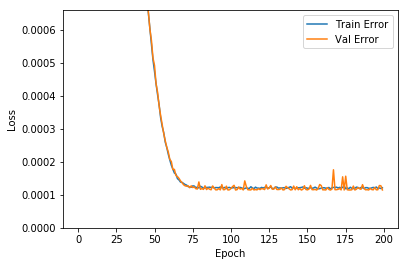

layer 1 weights: [ 0.58810043  1.2191179  -0.7667358  -0.49373174 -0.9644816 ]
layer 1 bias: -0.2882739, 0.013763791, 0.0, 0.0, 0.0
layer 2 weights: [-1.2276925], [0.6449497], [0.3820417], [-0.31140518], [0.42951703]
layer 2 bias: 0.014078419

mean of errors: 0.00037000390103907
standard deviation of errors: 0.010722098393605798
Errors Min: -0.028372044723485923 , Errors Max: 0.01341631820569908
Crosspoint Index: 5639 and 7879 out of 10000 points

Left crosspoint: -0.0048052301862647785 , Right crosspoint: 0.004556299262817573
Area of Normal (between the crosspoints): 0.9188989247128823
Area of Errors (between the crosspoints): 0.2231359254728352
Loss(blue area): 0.695762999240047

Initial loss: 0.695762999240047
-----Step 0
New loss: 0.6957629282041747     (learning rate: 1 )
-----Step 1
New loss: 0.6957630246757045     (learning rate: 1 )
-----Step 2
New loss: 0.6957629451443026     (learning rate: 0.1 )
-----Step 3
New loss: 0.6957632354494994     (learning rate: 0.1 )
-----Step 4
N

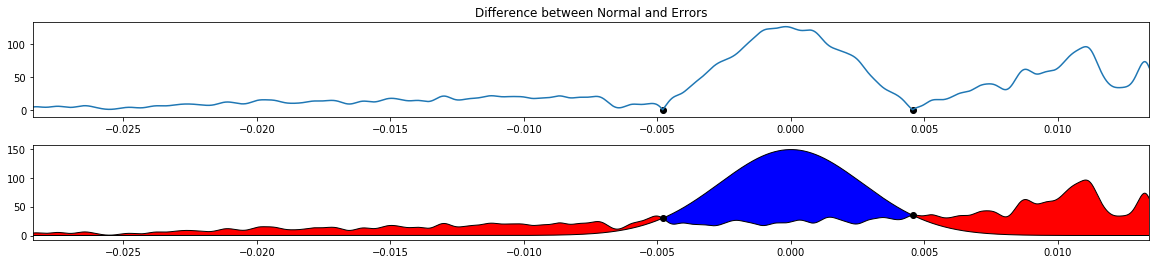

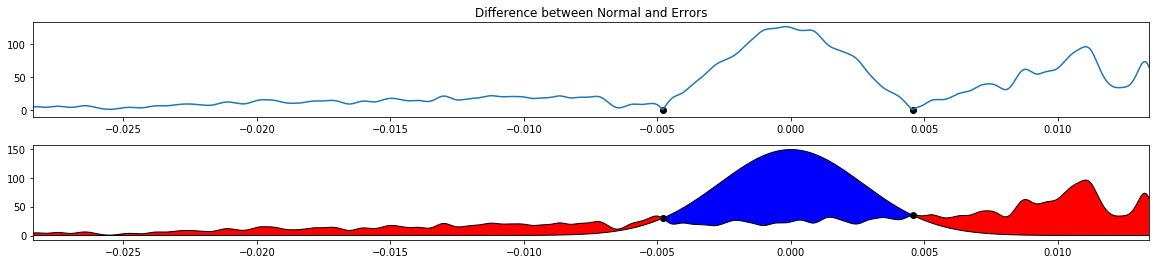

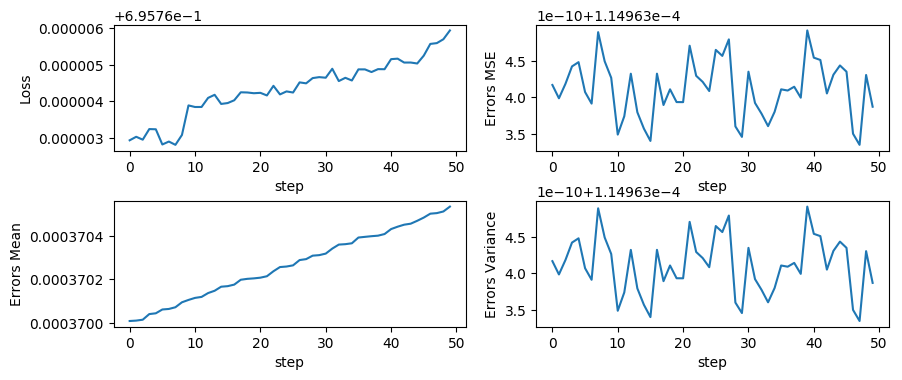

In [51]:
def train_dist(step_n=50):
  
  model = build_model(1)
  x, y = get_data(1000)
  errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)
  benchmark_loss = get_loss(errors, if_print=1, if_plot=1)
  print("\nInitial loss:", benchmark_loss)
  
  lr_init = 1
  lr = lr_init
  losses=[]; errors_mses=[]; errors_means=[]; errors_variances=[]
  for i in range(step_n):
    print("-----Step", i)
    if i < (step_n-1): if_print=0
    else: if_print=1
      
    # estimate gradient
    nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y, benchmark_loss)
    grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
    
    # update weights
    model=update_nodes(model, grads, nodes_delta_n, if_print=if_print)
    errors, mean, sigma = get_errors(model, x, y, if_train=0, if_print_weights=if_print, if_print_errors_stats=if_print)
    new_loss = get_loss(errors, if_print=if_print, if_plot=if_print)
    mse = (np.square(errors - errors.mean())).mean()
    losses.append(new_loss)
    errors_mses.append(mse)
    errors_means.append(mean)
    errors_variances.append(sigma**2)
    print("New loss:", new_loss, "    (learning rate:", lr, ")")
    lr = lr_init*10**(-i//10)
    
  #plot losses, errors mean, errors variance
  x = np.arange(step_n)

  print("x:", x)
  print("losses:", losses)
  print("mses", errors_mses)

  plt.figure(dpi=100, figsize=(10, 4))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(hspace=0.4, wspace=0.2)

  p1 = plt.subplot(221)
  p1.plot(x, losses)
  plt.xlabel("step")
  plt.ylabel("Loss")
  
  p2 = plt.subplot(222)
  p2.plot(x, errors_mses)
  plt.xlabel("step")
  plt.ylabel("Errors MSE")

  p3 = plt.subplot(223)
  p3.plot(x, errors_means)
  plt.xlabel("step")
  plt.ylabel("Errors Mean")

  p4 = plt.subplot(224)
  p4.plot(x, errors_variances)
  plt.xlabel("step")
  plt.ylabel("Errors Variance")

  return losses, errors_means, errors_variances
  
start_time = time.time()
losses, errors_means, errors_variances = train_dist()
print("--- %s seconds ---" % (time.time() - start_time))

In [39]:
def train_dist(step_n=50):
  
  model = build_model(1)
  x, y = get_data(1000)
  errors, mean, sigma = get_errors(model, x, y, if_train=1, if_print_weights=1, if_print_errors_stats=1)
  benchmark_loss = get_loss(errors, if_print=1, if_plot=1)
  print("\nInitial loss:", benchmark_loss)
  
  lr_init = 1
  lr = lr_init
  losses=[]; errors_mses=[]; errors_means=[]; errors_variances=[]
  for i in range(step_n):
    print("-----Step", i)
    if i < (step_n-1): if_print=0
    else: if_print=1
      
    # estimate gradient
    nodes_losses, nodes_delta_n = nodes_plus_delta_loss(model, x, y, benchmark_loss)
    grads = get_gradient(nodes_losses, nodes_delta_n, benchmark_loss)
    
    # update weights
    model=update_nodes(model, grads, nodes_delta_n, if_print=if_print)
    errors, mean, sigma = get_errors(model, x, y, if_train=0, if_print_weights=if_print, if_print_errors_stats=if_print)
    new_loss = get_loss(errors, if_print=if_print, if_plot=if_print)
    mse = (np.square(errors - errors.mean())).mean()
    losses.append(new_loss)
    errors_mses.append(mse)
    errors_means.append(mean)
    errors_variances.append(sigma**2)
    print("New loss:", new_loss, "    (learning rate:", lr, ")")
    lr = lr_init*10**(-i//10)
    
  #plot losses, errors mean, errors variance
  x = np.arange(step_n)

  print("x:", x)
  print("losses:", losses)
  print("mses", errors_mses)

  plt.figure(dpi=100, figsize=(10, 4))
  plt.xticks(fontsize=10)
  plt.subplots_adjust(hspace=0.4, wspace=0.2)

  p1 = plt.subplot(221)
  p1.plot(x, losses)
  plt.xlabel("step")
  plt.ylabel("Loss")
  
  p2 = plt.subplot(222)
  p2.plot(x, errors_mses)
  plt.xlabel("step")
  plt.ylabel("Errors MSE")

  p3 = plt.subplot(223)
  p3.plot(x, errors_means)
  plt.xlabel("step")
  plt.ylabel("Errors Mean")

  p4 = plt.subplot(224)
  p4.plot(x, errors_variances)
  plt.xlabel("step")
  plt.ylabel("Errors Variance")

  return losses, errors_means, errors_variances
  
start_time = time.time()
losses, errors_means, errors_variances = train_dist()
print("--- %s seconds ---" % (time.time() - start_time))

array([0, 1, 2, 3, 4])

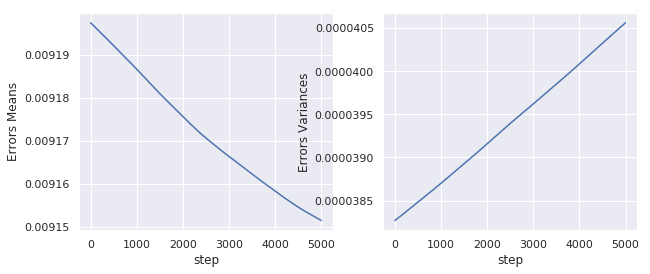

In [0]:
#delta_w = sys.float_info.min*10**302
def weights_plus_delta(layer_n, wb_n_n, if_print=False, delta = 10**-7):
  if if_print:
    print("------------------------------------------------------------")
    print("ΔW:", delta)
    print("\nOld weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
  model.layers[layer_n].trainable_variables[node_n].assign(model.layers[layer_n].trainable_variables[node_n]+delta)
  if if_print:
    print("\nNew weights of layer",layer_n, ", nodes", node_n, ":", model.layers[layer_n].trainable_variables[node_n])
    
def model_plus_delta(): 
  weights_plus_delta(0,0, if_print=0)
  weights_plus_delta(0,1)
  weights_plus_delta(1,0)
  weights_plus_delta(0,1)

def fumble(x, y, steps = 5000, if_earlystop=True, if_plot=False):
  means = []
  variances = []
  mean_min = 1
  patience_n = 20
  patience = patience_n
  for i in range(steps):
    model_plus_delta()
    errors, mean_, var_ = get_errors(model, x, y, if_train=0)
    errors = [np.abs(e) for e in errors]
    mean = np.mean(errors)
    var = np.var(errors)
    means.append(mean)
    variances.append(var)

    if i>0:
      if mean >= means[-2]:
        patience = patience-1
        if patience<=0: break
      else:
        patience = patience_n
    
  if if_plot:  
    x = np.arange(len(means))
    
    plt.figure(figsize=(10, 4))
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=0.3)

    p1 = plt.subplot(121)
    p1.plot(x, means)
    plt.xlabel("step")
    plt.ylabel("Errors Means")
    
    p2 = plt.subplot(122)
    p2.plot(x, variances)
    plt.xlabel("step")
    plt.ylabel("Errors Variances")
    
  return means, variances

means, variances = fumble(x, y, if_plot=1)